In [1]:
import os 
import torch 
import fnmatch
from torch import nn
from PIL import Image
from torchvision import transforms 
from tqdm.auto import tqdm 
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader 
import matplotlib.pyplot as plt 

C:\Users\Sania\gans-data-augmentation\gans_data_aug\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_PATHS = {
    "dataset": "./dataset/"
}

In [3]:
class PetrolPumpDataset(Dataset): 
    def __init__(self, img_dir, transform=None, extensions=['*.jpg', '*.jpeg', '*.png']):
        self.extensions = extensions 
        self.img_dir = img_dir
        self.image_paths = [f"{img_dir}/{img}" for img in os.listdir(img_dir) if any(fnmatch.fnmatch(img, ext) for ext in extensions)]
        self.transform = transform 
        
    def __len__(self): 
        return len(self.image_paths)
    
    def __getitem__(self, idx): 
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform: 
            image = self.transform(image)
            
        return image

In [9]:
dataset = PetrolPumpDataset(DATA_PATHS["dataset"], transform=transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
]))

In [10]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
img = next(iter(dataloader))
img[0].shape

torch.Size([3, 256, 256])

In [14]:
def show_tensor_images(image_tensor, num_images=1):
    image_tensor = image_tensor.detach().cpu()
    image_tensor = image_tensor.permute(1, 2, 0)

    # Handling normalization 
    image_tensor = torch.clamp(image_tensor, min=0, max=1)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(image_tensor)
    plt.axis('off')
    plt.show()


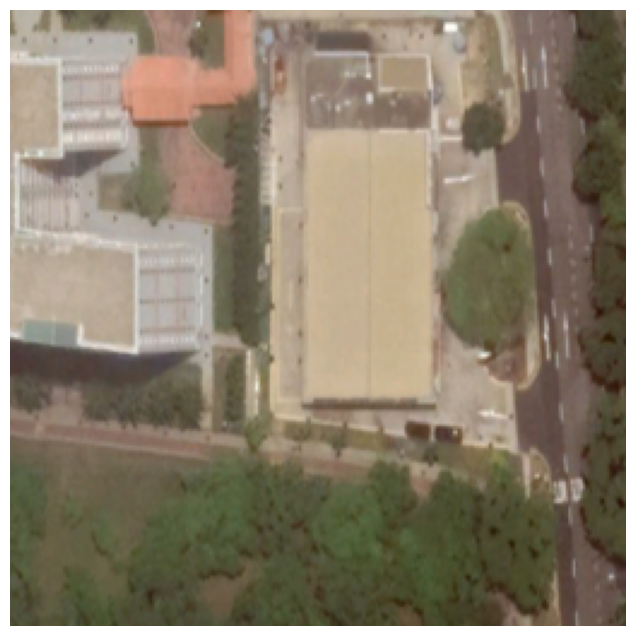

In [15]:
show_tensor_images(img[10])

In [13]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, input_dim=3*256*256, hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            generator_block(z_dim, hidden_dim),
            generator_block(hidden_dim, hidden_dim * 2),
            generator_block(hidden_dim * 2, hidden_dim * 4),
            generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, input_dim),
            nn.Sigmoid()
        )
        
    def generator_block(input_dim, output_dim): 
        return nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(output_dim), 
            nn.ReLU(inplace=True)
        )
        
    def forward(self, noise):
        return self.gen(noise)
    
    def get_gen(self):
        return self.gen

In [16]:
def get_noise(n_samples, z_dim): 
    return torch.randn(n_samples, z_dim)

In [17]:
class Discriminator(nn.Module):
    def __init__(self, input_dim=3*256*256, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            discriminator_block(input_dim, hidden_dim * 4),
            discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )
        
    def discriminator_block(input_dim, output_dim):
        return nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, image):
        return self.disc(image)
    
    def get_disc(self):
        return self.disc

In [20]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim):
    # Computing losses over fake samples 
    noise = get_noise(num_images, z_dim) 
    fake_images = gen(noise)
    disc_fake_pred = disc(fake.detach()) #Detaching the generator 
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    
    # Computing losses over real samples 
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    
    return (disc_fake_loss + disc_real_loss)/2

In [21]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim): 
    noise = get_noise(num_images, z_dim)
    fake_images = gen(noise)
    disc_fake_pred = disc(fake)
    
    return criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))